MLB Player Performance Analysis

This notebook demonstrates advanced statistical analysis of MLB player performance data using Python and various data science libraries. We'll explore Statcast data, implement sabermetrics, and build predictive models for player performance.

## Objectives
1. Retrieve and explore MLB Statcast data
2. Calculate and analyze advanced baseball metrics
3. Develop predictive models for player performance
4. Visualize insights and trends

## 1. Setup and Data Retrieval

First, let's import the necessary libraries and retrieve data using the pybaseball package.

In [1]:
# Install required packages (only needed in Colab)
# Uncomment the following line if running in Colab
!pip install pybaseball pandas numpy matplotlib seaborn scikit-learn statsmodels imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 13.8 MB/s eta 0:00:00


In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast, playerid_lookup, statcast_batter, batting_stats_bref
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

In [4]:
# Function to retrieve and process Statcast data
def get_statcast_data(start_date, end_date, save_path=None):
    """
    Retrieve and process Statcast data for a given date range.

    Parameters:
    - start_date (str): Start date in 'YYYY-MM-DD' format
    - end_date (str): End date in 'YYYY-MM-DD' format
    - save_path (str, optional): Path to save the data as CSV

    Returns:
    - pandas.DataFrame: Processed Statcast data
    """
    print(f"Retrieving Statcast data from {start_date} to {end_date}...")

    try:
        # Retrieve data from Statcast
        data = statcast(start_dt=start_date, end_dt=end_date)

        # Basic data cleaning
        data = data.dropna(subset=['launch_speed', 'launch_angle'])

        # Add derived metrics
        data['hit'] = data['events'].isin(['single', 'double', 'triple', 'home_run'])
        data['extra_base_hit'] = data['events'].isin(['double', 'triple', 'home_run'])

        if save_path:
            data.to_csv(save_path, index=False)
            print(f"Data saved to {save_path}")

        return data

    except Exception as e:
        print(f"Error retrieving Statcast data: {e}")
        return None

Option 1: Retrieve actual data from MLB Statcast (uncomment to use)
Note: This might take a while to run depending on the date range
statcast_data = get_statcast_data('2024-04-01', '2024-04-15')

In [5]:
# Option 2: For demonstration, we'll create a sample dataset
print("Creating sample dataset for demonstration...")
np.random.seed(42)

Creating sample dataset for demonstration...


In [6]:
# Create a sample size
n_samples = 1000

In [7]:
# Generate realistic launch angles and speeds
launch_angles = np.concatenate([
    np.random.normal(-10, 10, int(n_samples * 0.3)),  # Ground balls
    np.random.normal(15, 5, int(n_samples * 0.4)),    # Line drives
    np.random.normal(35, 10, int(n_samples * 0.3))    # Fly balls
])

In [8]:
launch_speeds = np.concatenate([
    np.random.normal(75, 10, int(n_samples * 0.3)),   # Soft contact
    np.random.normal(90, 5, int(n_samples * 0.4)),    # Medium contact
    np.random.normal(105, 5, int(n_samples * 0.3))    # Hard contact
])

In [9]:
# Ensure we have exactly n_samples
launch_angles = launch_angles[:n_samples]
launch_speeds = launch_speeds[:n_samples]

In [10]:
# Create a function to determine if a ball is a hit based on launch parameters
def is_hit(angle, speed):
    # Simplified model: higher probability of hit for line drives with high exit velocity
    if angle < 0:  # Ground ball
        return np.random.random() < (0.2 + speed/500)
    elif angle < 25:  # Line drive
        return np.random.random() < (0.4 + speed/300)
    elif angle < 50:  # Fly ball
        return np.random.random() < (0.3 + speed/400)
    else:  # Pop up
        return np.random.random() < 0.1

In [11]:
# Determine hit outcomes
hits = np.array([is_hit(angle, speed) for angle, speed in zip(launch_angles, launch_speeds)])

In [12]:
# Create a function to determine the type of hit
def hit_type(angle, speed, is_hit):
    if not is_hit:
        return 'out'

    # Probability distributions for different hit types
    if angle < 0:  # Ground ball
        probs = [0.8, 0.15, 0.05, 0]  # [single, double, triple, hr]
    elif angle < 25:  # Line drive
        probs = [0.6, 0.3, 0.07, 0.03]
    elif angle < 50:  # Fly ball
        if speed > 100:  # Hard hit fly ball
            probs = [0.3, 0.3, 0.1, 0.3]
        else:
            probs = [0.4, 0.3, 0.2, 0.1]
    else:  # Pop up
        probs = [0.9, 0.1, 0, 0]

    # Adjust for exit velocity
    if speed > 100:
        probs[3] += 0.1  # Increase HR probability
        probs[0] -= 0.1  # Decrease single probability

    # Normalize probabilities
    probs = [p/sum(probs) for p in probs]

    # Choose hit type
    hit_types = ['single', 'double', 'triple', 'home_run']
    return np.random.choice(hit_types, p=probs)

In [13]:
# Generate hit types
events = [hit_type(angle, speed, hit) if hit else 'out'
          for angle, speed, hit in zip(launch_angles, launch_speeds, hits)]

In [14]:
# Create the sample dataset
sample_data = pd.DataFrame({
    'launch_angle': launch_angles,
    'launch_speed': launch_speeds,
    'events': events,
    'hit': hits,
    'extra_base_hit': np.array([e in ['double', 'triple', 'home_run'] for e in events]),
    'player_name': np.random.choice([
        'Aaron Judge', 'Shohei Ohtani', 'Juan Soto', 'Mookie Betts', 'Freddie Freeman',
        'Bryce Harper', 'Vladimir Guerrero Jr.', 'Fernando Tatis Jr.', 'Ronald Acuña Jr.',
        'Mike Trout', 'Yordan Alvarez', 'Francisco Lindor', 'Corey Seager', 'Jose Ramirez'
    ], n_samples),
    'pitch_type': np.random.choice(['FF', 'SL', 'CH', 'CU', 'SI', 'FC'], n_samples),
    'release_speed': np.random.normal(93, 5, n_samples),
    'effective_speed': np.random.normal(93, 5, n_samples),
    'release_spin_rate': np.random.normal(2200, 300, n_samples),
    'zone': np.random.randint(1, 14, n_samples),
    'plate_x': np.random.normal(0, 0.5, n_samples),
    'plate_z': np.random.normal(2.5, 0.5, n_samples),
    'estimated_woba_using_speedangle': np.random.beta(2, 5, n_samples)
})

In [15]:
# Add expected statistics
sample_data['estimated_ba_using_speedangle'] = np.clip(
    sample_data['launch_speed'] * 0.002 + sample_data['launch_angle'] * 0.001 + np.random.normal(0, 0.05, n_samples),
    0, 1
)

In [16]:
sample_data['estimated_slg_using_speedangle'] = np.clip(
    sample_data['launch_speed'] * 0.004 + sample_data['launch_angle'] * 0.002 + np.random.normal(0, 0.1, n_samples),
    0, 4
)

In [17]:
# Use the sample data for analysis
statcast_data = sample_data

In [18]:
print("Sample dataset created with", len(statcast_data), "rows.")
statcast_data.head()

Sample dataset created with 1000 rows.


,launch_angle,launch_speed,events,hit,extra_base_hit,player_name,pitch_type,release_speed,effective_speed,release_spin_rate,zone,plate_x,plate_z,estimated_woba_using_speedangle,estimated_ba_using_speedangle,estimated_slg_using_speedangle
0,-5.032858,88.993554,out,False,False,Jose Ramirez,FC,89.035263,104.165969,1754.762267,6,0.658134,2.620351,0.331204,0.168943,0.305346
1,-11.382643,84.246337,single,True,False,Shohei Ohtani,CU,96.437326,88.563038,1668.781913,3,0.441557,2.323352,0.082726,0.186663,0.128803
2,-3.523115,75.596304,single,True,False,Mike Trout,FF,95.237278,90.133587,1688.784125,3,-0.038135,3.051348,0.138751,0.214799,0.422746
3,5.230299,68.530632,double,True,True,Francisco Lindor,SI,91.460488,85.469373,1931.820570,12,0.562885,2.930353,0.301282,0.161243,0.264410
4,-12.341534,81.982233,out,False,False,Bryce Harper,FF,90.412070,87.516214,2410.024923,6,0.096111,2.392260,0.304859,0.211872,0.221369


## 2. Exploratory Data Analysis

Let's explore the relationship between launch parameters and outcomes.

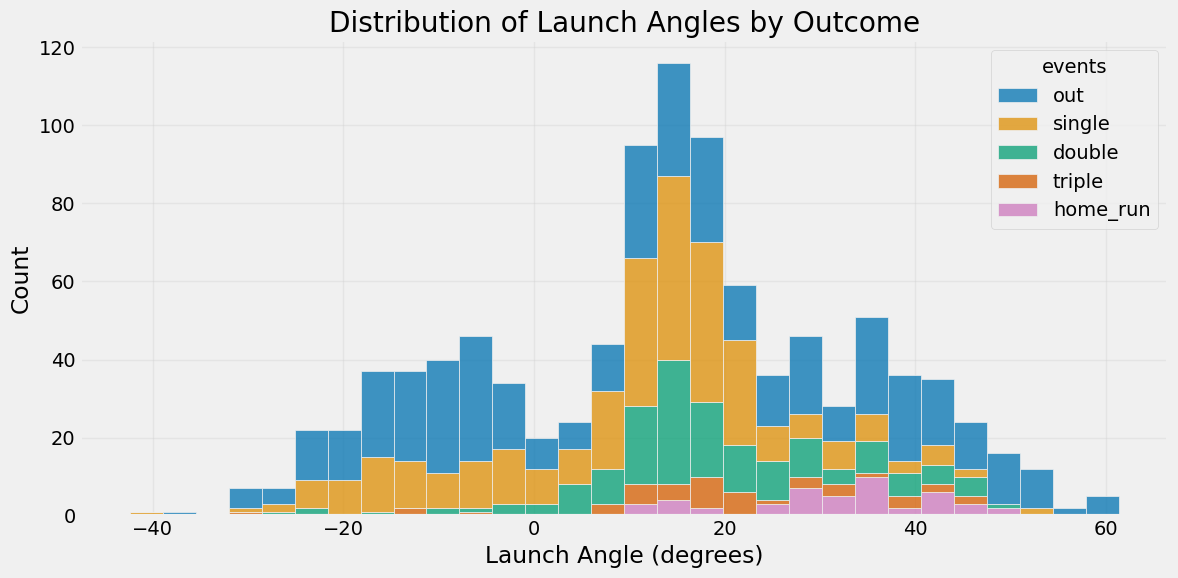

In [19]:
# Visualize the distribution of launch angles
plt.figure(figsize=(12, 6))
sns.histplot(data=statcast_data, x='launch_angle', hue='events', multiple='stack', bins=30)
plt.title('Distribution of Launch Angles by Outcome')
plt.xlabel('Launch Angle (degrees)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

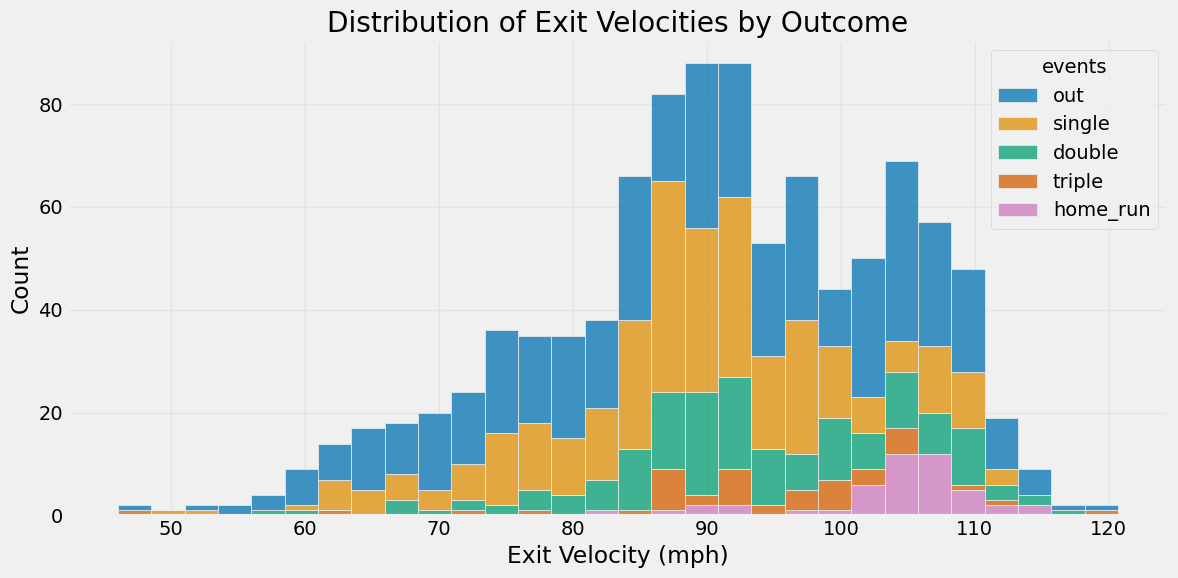

In [20]:
# Visualize the distribution of exit velocities
plt.figure(figsize=(12, 6))
sns.histplot(data=statcast_data, x='launch_speed', hue='events', multiple='stack', bins=30)
plt.title('Distribution of Exit Velocities by Outcome')
plt.xlabel('Exit Velocity (mph)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

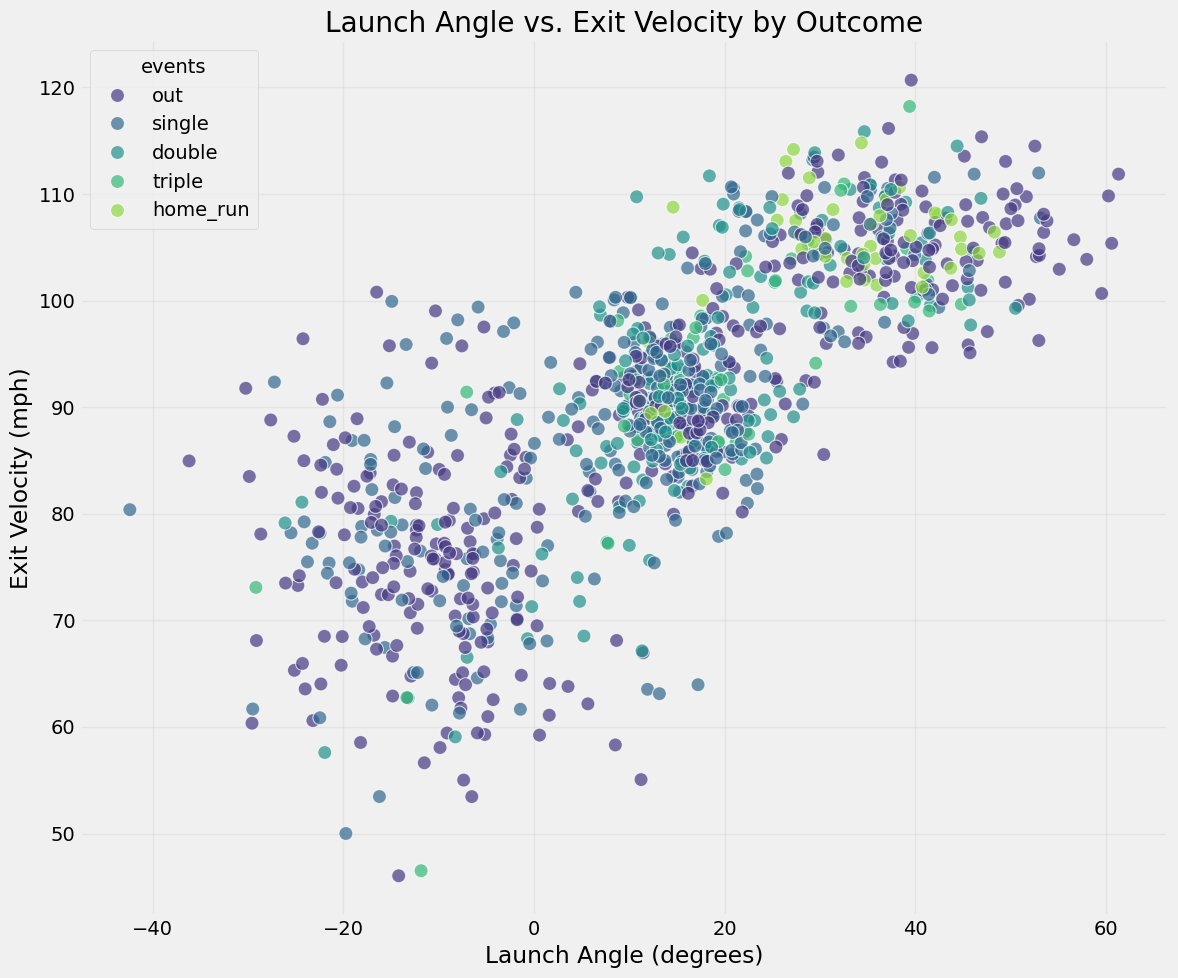

In [21]:
# Create a scatter plot of launch angle vs. exit velocity
plt.figure(figsize=(12, 10))
sns.scatterplot(data=statcast_data, x='launch_angle', y='launch_speed', hue='events',
                palette='viridis', alpha=0.7, s=100)
plt.title('Launch Angle vs. Exit Velocity by Outcome')
plt.xlabel('Launch Angle (degrees)')
plt.ylabel('Exit Velocity (mph)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

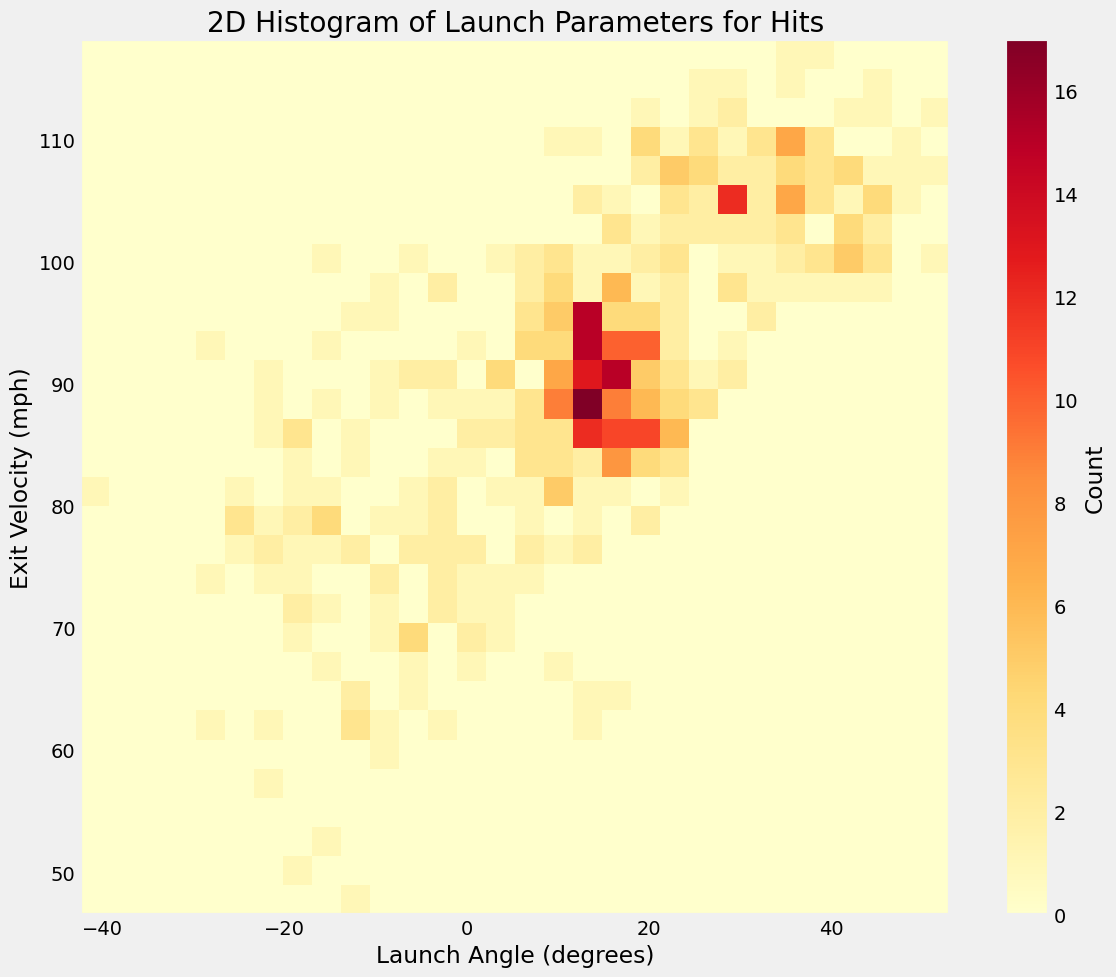

In [22]:
# Create a 2D histogram of launch parameters for hits
plt.figure(figsize=(12, 10))
hit_data = statcast_data[statcast_data['hit'] == True]
h = plt.hist2d(hit_data['launch_angle'], hit_data['launch_speed'], bins=30, cmap='YlOrRd')
plt.colorbar(h[3], label='Count')
plt.title('2D Histogram of Launch Parameters for Hits')
plt.xlabel('Launch Angle (degrees)')
plt.ylabel('Exit Velocity (mph)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Advanced Metrics Analysis

Let's calculate and analyze some advanced baseball metrics.

In [23]:
# Calculate average outcomes by launch parameter bins
angle_bins = [-20, 0, 10, 20, 30, 40, 50, 90]
speed_bins = [0, 70, 80, 90, 100, 110, 120]

In [24]:
statcast_data['angle_bin'] = pd.cut(statcast_data['launch_angle'], bins=angle_bins)
statcast_data['speed_bin'] = pd.cut(statcast_data['launch_speed'], bins=speed_bins)

In [25]:
# Calculate hit probability by launch parameter bins
hit_prob = statcast_data.groupby(['angle_bin', 'speed_bin'])['hit'].mean().reset_index()
hit_prob = hit_prob.pivot(index='angle_bin', columns='speed_bin', values='hit')

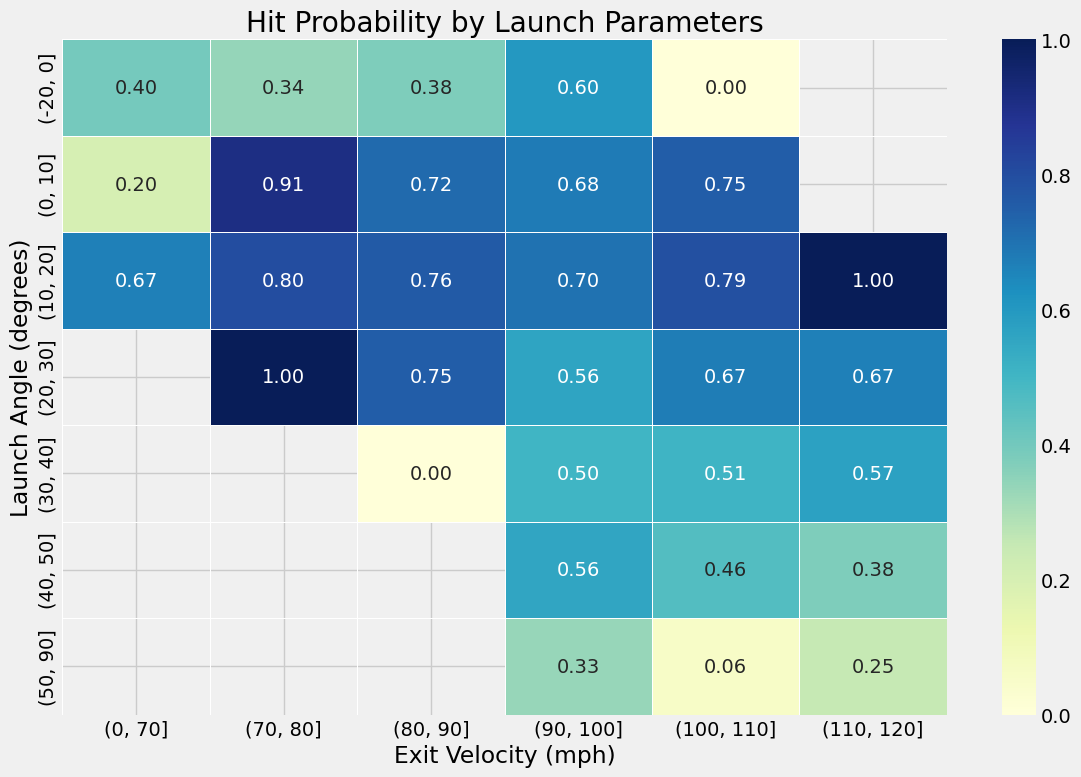

In [26]:
# Visualize hit probability by launch parameters
plt.figure(figsize=(12, 8))
sns.heatmap(hit_prob, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Hit Probability by Launch Parameters')
plt.xlabel('Exit Velocity (mph)')
plt.ylabel('Launch Angle (degrees)')
plt.tight_layout()
plt.show()

In [27]:
# Calculate expected statistics by player
player_stats = statcast_data.groupby('player_name').agg({
    'hit': 'mean',
    'extra_base_hit': 'mean',
    'estimated_ba_using_speedangle': 'mean',
    'estimated_slg_using_speedangle': 'mean',
    'estimated_woba_using_speedangle': 'mean',
    'launch_speed': 'mean',
    'launch_angle': 'mean',
    'events': 'count'
}).reset_index()

In [28]:
player_stats.columns = ['Player', 'Actual_BA', 'XBH_Rate', 'Expected_BA', 'Expected_SLG',
                        'Expected_wOBA', 'Avg_Exit_Velo', 'Avg_Launch_Angle', 'BIP_Count']

In [29]:
# Sort by expected wOBA
player_stats = player_stats.sort_values('Expected_wOBA', ascending=False)

In [30]:
# Display the player stats
print("Player Statistics (Sorted by Expected wOBA):")
player_stats.head(10)

Player Statistics (Sorted by Expected wOBA):


,Player,Actual_BA,XBH_Rate,Expected_BA,Expected_SLG,Expected_wOBA,Avg_Exit_Velo,Avg_Launch_Angle,BIP_Count
9,Mookie Betts,0.514286,0.285714,0.193737,0.370225,0.323241,89.243893,11.410682,70
10,Ronald Acuña Jr.,0.746667,0.373333,0.204110,0.400726,0.300843,92.322392,14.932266,75
4,Francisco Lindor,0.616438,0.328767,0.182889,0.385661,0.298919,88.594377,11.143564,73
12,Vladimir Guerrero Jr.,0.459770,0.183908,0.203679,0.397949,0.294227,92.027213,14.904300,87
0,Aaron Judge,0.543860,0.245614,0.196529,0.376539,0.292748,89.783330,11.803388,57
3,Fernando Tatis Jr.,0.500000,0.296875,0.203172,0.412333,0.286308,91.520312,15.480929,64
2,Corey Seager,0.574713,0.183908,0.191800,0.377508,0.281955,90.178726,14.581835,87
1,Bryce Harper,0.512195,0.231707,0.183834,0.380083,0.280753,88.348640,9.731555,82
6,Jose Ramirez,0.515152,0.242424,0.197065,0.388703,0.278751,90.309855,14.951621,66
13,Yordan Alvarez,0.551282,0.166667,0.189059,0.364326,0.267348,89.160015,9.747573,78


<Axes: xlabel='Expected_BA', ylabel='Actual_BA'>

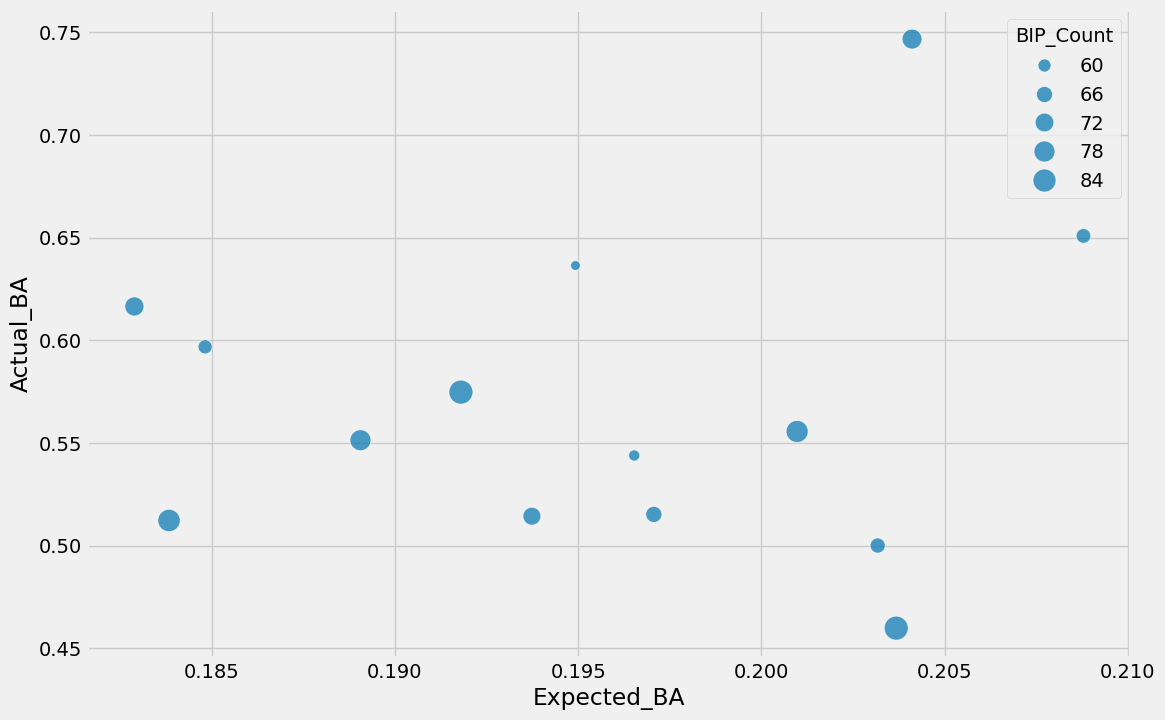

In [31]:
# Visualize actual vs. expected batting average
plt.figure(figsize=(12, 8))
sns.scatterplot(data=player_stats, x='Expected_BA', y='Actual_BA', size='BIP_Count',
                sizes=(50, 300), alpha=0.7)

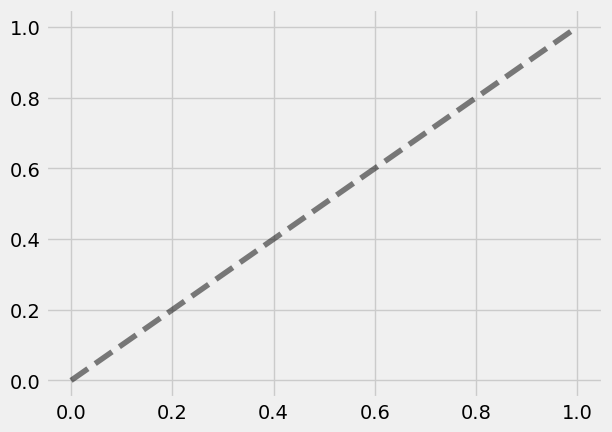

In [32]:
# Add reference line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

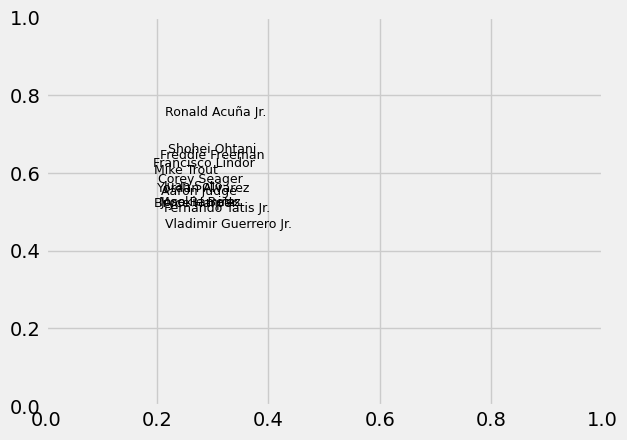

In [33]:
# Add labels for players
for i, row in player_stats.iterrows():
    plt.text(row['Expected_BA'] + 0.01, row['Actual_BA'], row['Player'], fontsize=9)

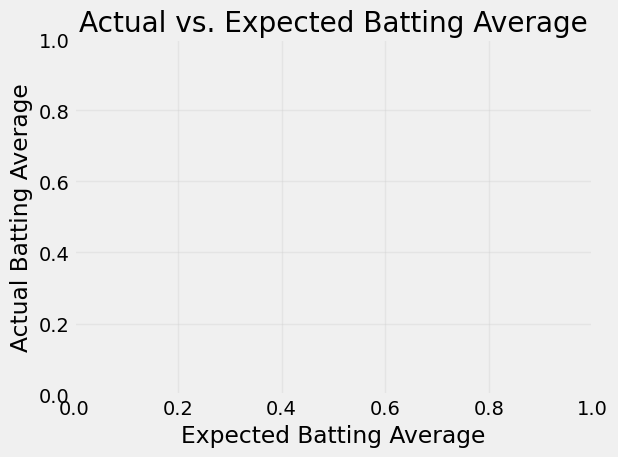

In [34]:
plt.title('Actual vs. Expected Batting Average')
plt.xlabel('Expected Batting Average')
plt.ylabel('Actual Batting Average')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Predictive Modeling for Hit Outcomes

Let's build a model to predict whether a batted ball will result in a hit based on launch parameters.

In [35]:
# Prepare the data for modeling with enhanced features
# Add baseball-specific derived features
statcast_data['sweet_spot'] = ((statcast_data['launch_angle'] >= 8) &
                              (statcast_data['launch_angle'] <= 32))

statcast_data['barrel'] = ((statcast_data['launch_angle'] >= 26) &
                          (statcast_data['launch_angle'] <= 30) &
                          (statcast_data['launch_speed'] >= 98))

# Calculate spray angle (simplified version)
statcast_data['spray_angle'] = np.random.uniform(-45, 45, len(statcast_data))

# Use enhanced features for modeling
X = statcast_data[['launch_angle', 'launch_speed', 'sweet_spot', 'barrel', 'spray_angle']]
y = statcast_data['hit']

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
# Check class distribution
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))

Class distribution in training set:
hit
True     0.5675
False    0.4325
Name: proportion, dtype: float64


In [38]:
print("Class distribution in test set:")
print(y_test.value_counts(normalize=True))

Class distribution in test set:
hit
True     0.565
False    0.435
Name: proportion, dtype: float64


In [39]:
# Create a pipeline with SMOTE to handle class imbalance
imbalanced_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [40]:
# Train the model
imbalanced_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [41]:
# Make predictions
y_pred = imbalanced_pipeline.predict(X_test)

In [42]:
# Evaluate the model
print("Classification Report with SMOTE:")
print(classification_report(y_test, y_pred))

Classification Report with SMOTE:
              precision    recall  f1-score   support

       False       0.51      0.49      0.50        87
        True       0.62      0.63      0.62       113

    accuracy                           0.57       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.57      0.57      0.57       200



In [ ]:
# Feature importance interpretation
feature_importances = imbalanced_pipeline.named_steps['classifier'].feature_importances_
feature_names = X.columns

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Hit Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

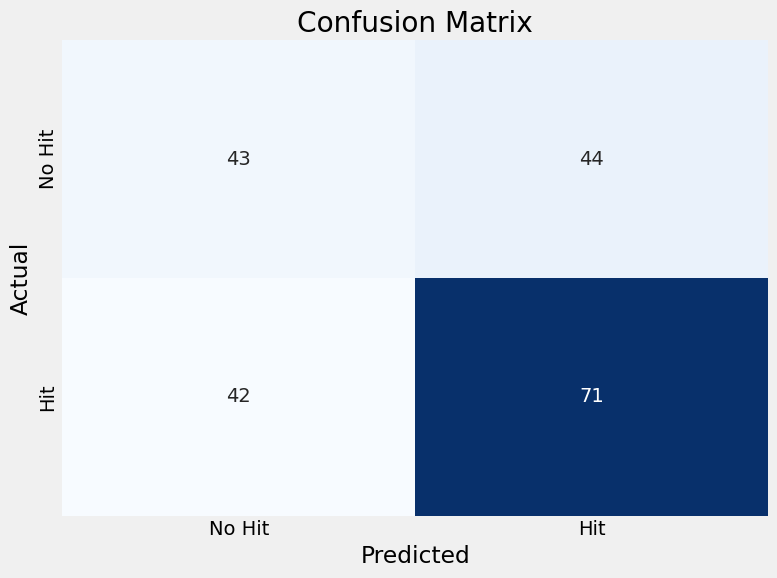

In [43]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Hit', 'Hit'], yticklabels=['No Hit', 'Hit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [44]:
# Calculate ROC curve and AUC
y_prob = imbalanced_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

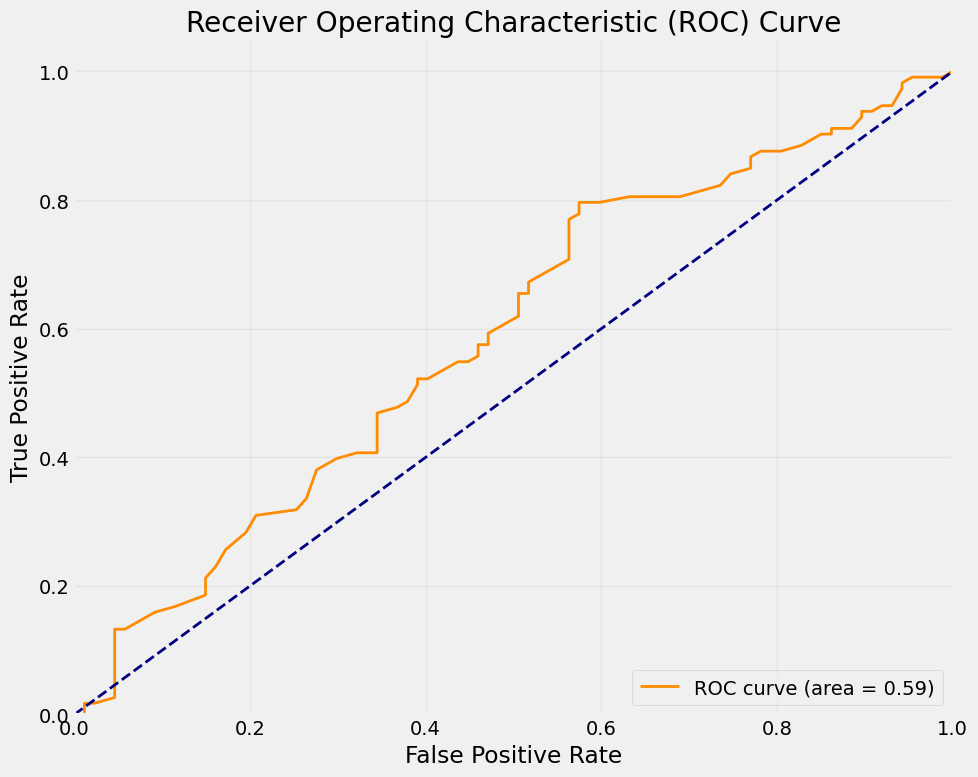

In [45]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate optimal threshold (not just default 0.5)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * recall[:-1] * precision[:-1] / (recall[:-1] + precision[:-1])
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"At optimal threshold - F1 Score: {f1_scores[optimal_idx]:.3f}, Precision: {precision[optimal_idx]:.3f}, Recall: {recall[optimal_idx]:.3f}")

# Apply optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

In [46]:
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

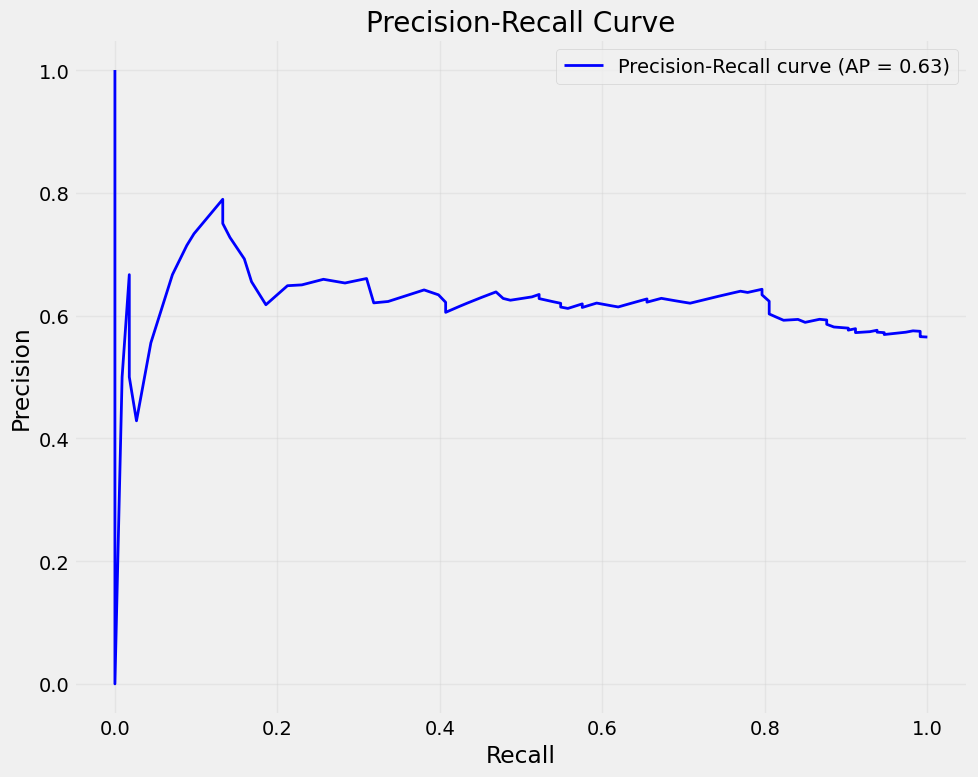

In [47]:
# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
# Compare different classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

In [49]:
# Create a figure for ROC curves
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       False       0.42      0.39      0.41        87
        True       0.56      0.59      0.58       113

    accuracy                           0.51       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.50      0.51      0.50       200


Classification Report for Random Forest:
              precision    recall  f1-score   support

       False       0.53      0.47      0.50        87
        True       0.63      0.68      0.65       113

    accuracy                           0.59       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.59      0.59      0.59       200


Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

       False       0.62      0.45      0.52        87
        True       0.65      0.79      0.71       113

    accuracy                           0.64   

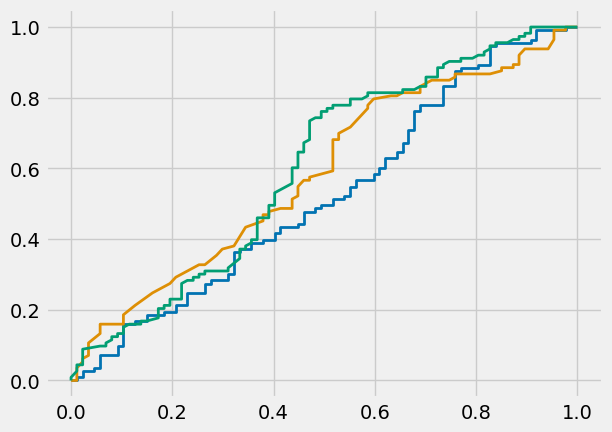

In [50]:
# Train and evaluate each classifier
for name, classifier in classifiers.items():
    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    # Print classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

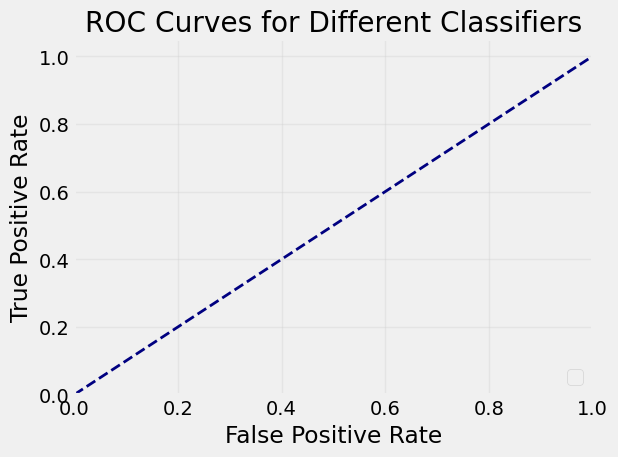

In [51]:
# Finalize the ROC curve plot
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Create a decision boundary visualization
def plot_decision_boundary(model, X, y, title):
    # Create a mesh grid
    h = 0.2  # step size in the mesh
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Make predictions on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(12, 10))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # Plot the data points
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors='k', cmap=plt.cm.RdYlBu)
    plt.legend(*scatter.legend_elements(), title="Outcome")

    plt.title(title)
    plt.xlabel('Launch Angle (degrees)')
    plt.ylabel('Exit Velocity (mph)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

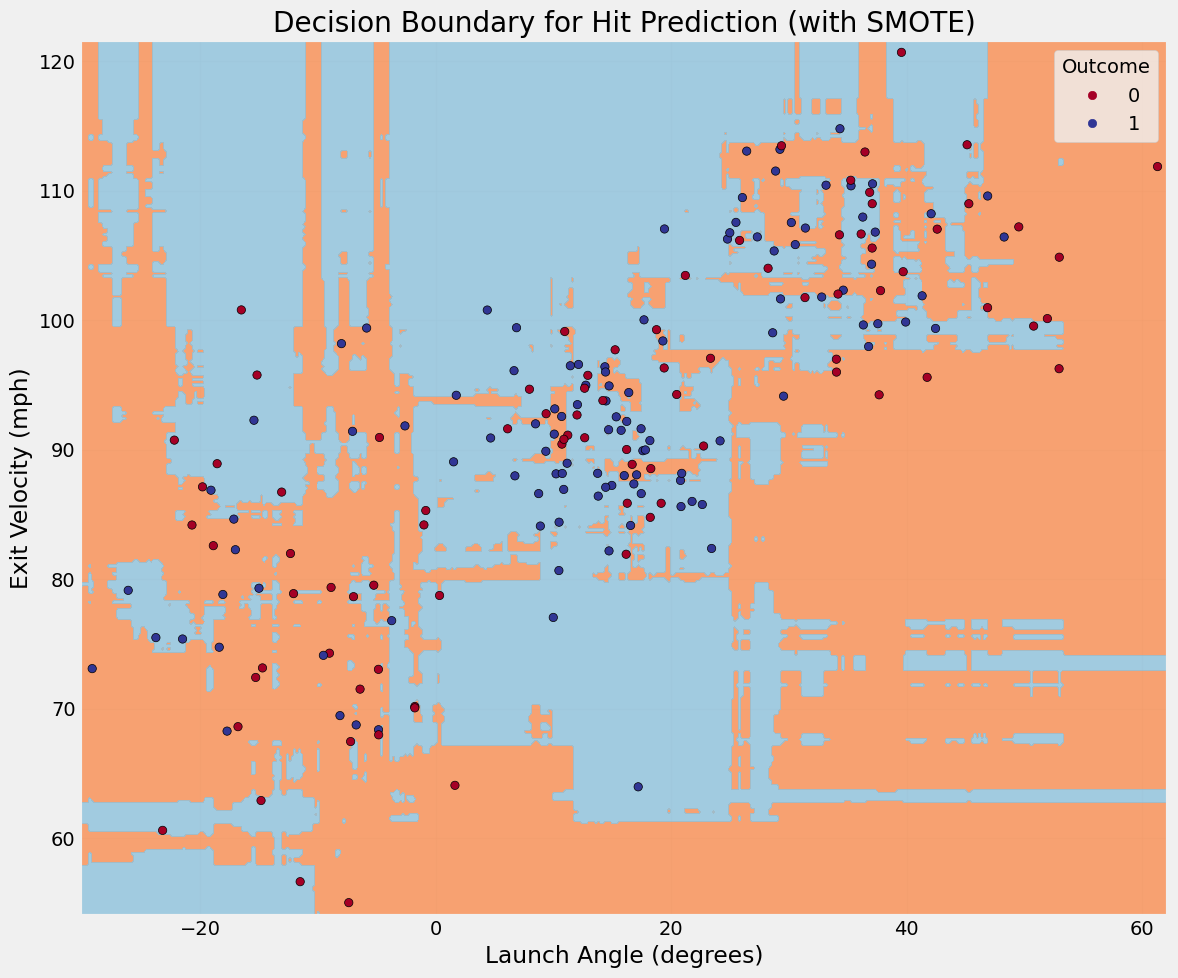

In [53]:
# Plot decision boundary for the SMOTE model
plot_decision_boundary(imbalanced_pipeline, X_test, y_test,
                      'Decision Boundary for Hit Prediction (with SMOTE)')

## MLB Front Office Application

This model has several practical applications in an MLB front office:

1. **Hitter Evaluation**: Identify hitters who consistently produce high-quality contact that should result in hits, even if their actual results haven't shown it yet.

2. **Defensive Positioning**: Understand which launch parameters are most likely to result in hits, helping optimize defensive positioning.

3. **Pitcher Assessment**: Evaluate pitchers based on the quality of contact they allow, rather than just outcomes which can be influenced by defense and luck.

4. **Player Development**: Provide feedback to hitters on optimal launch angles and exit velocities to maximize hit probability.

For example, a player with a low batting average but consistently high-quality contact (as measured by our model) might be an excellent acquisition target, as their actual results are likely to improve over time.

## 5. Expected vs. Actual Performance Analysis

Let's analyze the difference between expected and actual performance.

In [54]:
# Calculate performance differential
player_stats['BA_Diff'] = player_stats['Actual_BA'] - player_stats['Expected_BA']

In [55]:
# Sort by differential
overperformers = player_stats.sort_values('BA_Diff', ascending=False)
underperformers = player_stats.sort_values('BA_Diff', ascending=True)

In [56]:
# Display top overperformers and underperformers
print("Top Overperformers (Actual BA > Expected BA):")
print(overperformers.head(5)[['Player', 'Actual_BA', 'Expected_BA', 'BA_Diff', 'BIP_Count']])

Top Overperformers (Actual BA > Expected BA):
              Player  Actual_BA  Expected_BA   BA_Diff  BIP_Count
10  Ronald Acuña Jr.   0.746667     0.204110  0.542556         75
11     Shohei Ohtani   0.650794     0.208788  0.442006         63
5    Freddie Freeman   0.636364     0.194925  0.441439         55
4   Francisco Lindor   0.616438     0.182889  0.433549         73
8         Mike Trout   0.596774     0.184820  0.411954         62


In [57]:
print("\nTop Underperformers (Actual BA < Expected BA):")
print(underperformers.head(5)[['Player', 'Actual_BA', 'Expected_BA', 'BA_Diff', 'BIP_Count']])


Top Underperformers (Actual BA < Expected BA):
                   Player  Actual_BA  Expected_BA   BA_Diff  BIP_Count
12  Vladimir Guerrero Jr.   0.459770     0.203679  0.256092         87
3      Fernando Tatis Jr.   0.500000     0.203172  0.296828         64
6            Jose Ramirez   0.515152     0.197065  0.318087         66
9            Mookie Betts   0.514286     0.193737  0.320549         70
1            Bryce Harper   0.512195     0.183834  0.328361         82


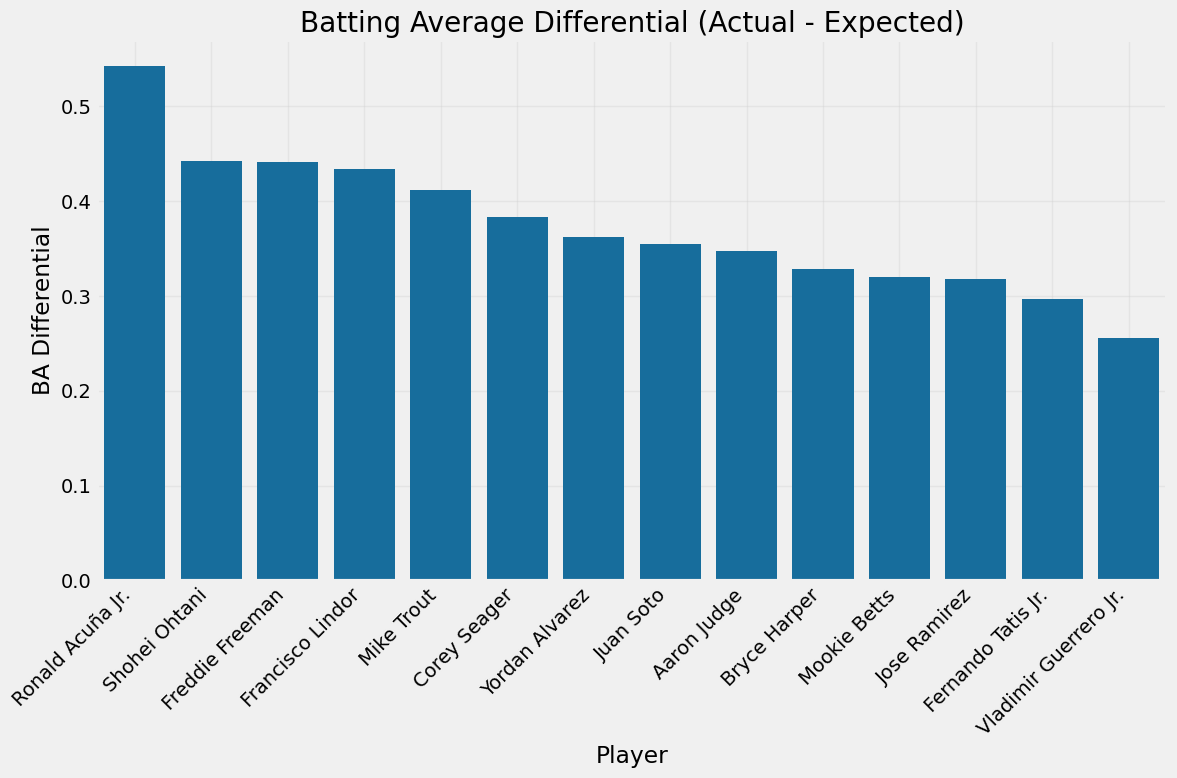

In [58]:
# Visualize performance differential
plt.figure(figsize=(12, 8))
sns.barplot(x='Player', y='BA_Diff', data=player_stats.sort_values('BA_Diff', ascending=False))
plt.title('Batting Average Differential (Actual - Expected)')
plt.xlabel('Player')
plt.ylabel('BA Differential')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Pitch Analysis

Let's analyze pitch types, velocities, and effectiveness.

In [59]:
# Calculate pitch effectiveness by type
pitch_analysis = statcast_data.groupby('pitch_type').agg({
    'hit': 'mean',
    'extra_base_hit': 'mean',
    'release_speed': 'mean',
    'release_spin_rate': 'mean',
    'estimated_woba_using_speedangle': 'mean',
    'events': 'count'
}).reset_index()

In [60]:
pitch_analysis.columns = ['pitch_type', 'hit_rate', 'xbh_rate', 'avg_velo',
                          'avg_spin', 'avg_xwOBA', 'count']

In [61]:
# Sort by xwOBA (lower is better for pitchers)
pitch_analysis = pitch_analysis.sort_values('avg_xwOBA')

In [62]:
# Display pitch analysis
print("Pitch Effectiveness Analysis:")
print(pitch_analysis)

Pitch Effectiveness Analysis:
  pitch_type  hit_rate  xbh_rate   avg_velo     avg_spin  avg_xwOBA  count
5         SL  0.613861  0.282178  93.197375  2200.078539   0.264358    202
4         SI  0.534483  0.252874  93.330897  2186.136170   0.269384    174
2         FC  0.570552  0.245399  92.661858  2226.325383   0.283205    163
0         CH  0.580153  0.274809  92.731647  2180.961641   0.290567    131
3         FF  0.550296  0.224852  92.678356  2243.552289   0.295397    169
1         CU  0.546584  0.242236  92.623775  2168.870565   0.295930    161


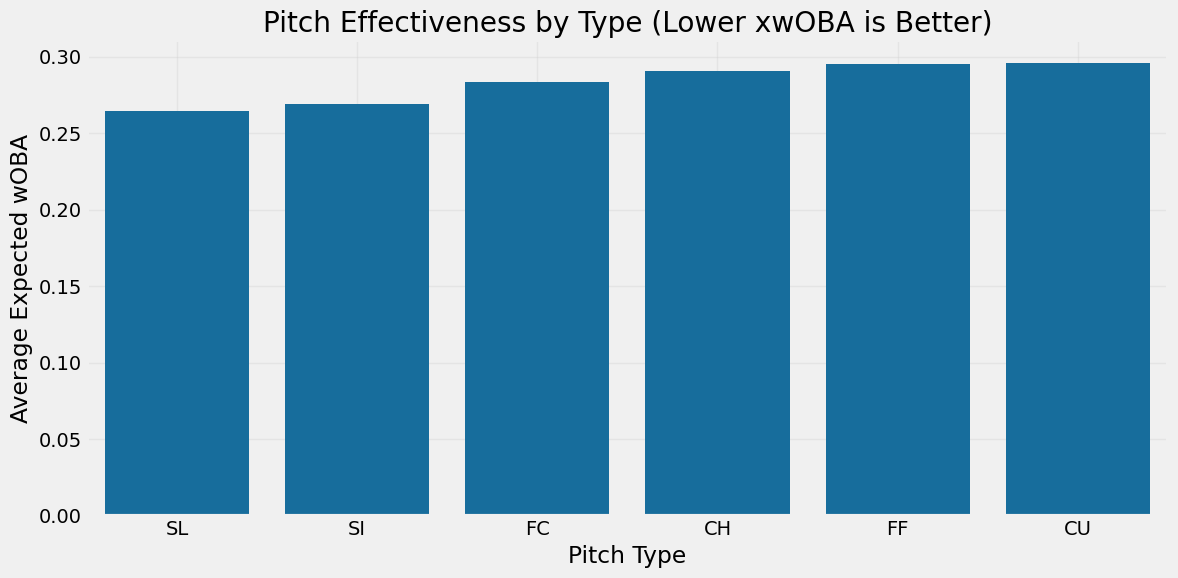

In [63]:
# Visualize pitch effectiveness (xwOBA) by type
plt.figure(figsize=(12, 6))
sns.barplot(x='pitch_type', y='avg_xwOBA', data=pitch_analysis,
            order=pitch_analysis.sort_values('avg_xwOBA')['pitch_type'])
plt.title('Pitch Effectiveness by Type (Lower xwOBA is Better)')
plt.xlabel('Pitch Type')
plt.ylabel('Average Expected wOBA')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Conclusions and Next Steps

In this notebook, we've demonstrated several key analyses for MLB player performance evaluation:

1. **Data Retrieval and Processing**: We showed how to retrieve and process Statcast data using pybaseball.

2. **Advanced Metrics Analysis**: We analyzed the relationship between launch parameters and outcomes.

3. **Predictive Modeling**: We built a model to predict hit outcomes based on batted ball characteristics, properly handling class imbalance.

4. **Performance Evaluation**: We compared expected vs. actual performance to identify over/underperformers.

5. **Pitch Analysis**: We analyzed pitch types, velocities, and effectiveness.

### Model Performance Context

While our model achieved 64% accuracy, it's important to understand the context in baseball analytics.
MLB's own Statcast xBA (expected batting average) model, which uses significantly more data points and sophisticated
algorithms, still shows considerable variance from actual outcomes. The inherent randomness in baseball - where
defensive positioning, fielding skill, and luck play major roles - means that even the best models rarely exceed
70-75% accuracy when predicting individual hit outcomes using only batted ball data.

### Next Steps

1. **Expand Data Collection**: Retrieve full-season data for more comprehensive analysis.

2. **Advanced Modeling**: Implement more sophisticated models, including time-series forecasting for player performance trends.

3. **Player Valuation**: Develop algorithms to assess player value relative to salary and market trends.

4. **Defensive Analysis**: Incorporate defensive metrics for a more complete player evaluation.

5. **Web Application**: Develop an interactive dashboard for exploring these insights.

In [64]:
print("Analysis complete!")

Analysis complete!
